In [21]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import os

def calculate_distance_from_point_to_station(row, given_point_coord):
    station_coord = (row['LATITUDE:'], row['LONGITUDE:'])
    # given_point_coord = (-15.789343, -47.925756)
    return geodesic(station_coord, given_point_coord).kilometers

df_all_stations = pd.read_csv("../data/all_stations.csv", decimal=",", sep=";")

# given_point_coord = (-16.012222, -47.557417)
# df_all_stations["Distancia"] = df_all_stations.apply(lambda x: calculate_distance_from_point_to_station(x, given_point_coord), axis=1) 

# df_nearest_stations = df_all_stations[df_all_stations["Distancia"] < 50]

# df_point_stations = df_all_stations[df_all_stations["Distancia"] < 1]

# Estaçoes do DF
codes_of_stations_to_analyze = ["A001", "A042", "A045", "A046", "A047"]

stations_data = []

# stations_files_to_read = set()

for code in codes_of_stations_to_analyze:
    station_info = df_all_stations[df_all_stations["CODIGO (WMO):"] == code]

    latitude = station_info["LATITUDE:"].iloc[0]
    longitude = station_info["LONGITUDE:"].iloc[0]

    station_coord = (latitude, longitude)

    df_all_stations["Distancia"] = df_all_stations.apply(lambda x: calculate_distance_from_point_to_station(x, station_coord), axis=1) 
    df_nearest_stations = df_all_stations[(df_all_stations["Distancia"] != 0) & (df_all_stations["Distancia"] < 50)]

    station_data = { 
        "code": code,
        "station_info": station_info,
        "nearest_stations_info": df_nearest_stations,
    }

    # df_nearest_stations["Arquivo"].apply(lambda x: stations_files_to_read.add(x))
    # stations_files_to_read.add(station_info["Arquivo"].iloc[0])
    stations_data.append(station_data)

print(stations_data)
# print(stations_files_to_read)

[{'code': 'A001', 'station_info':     REGI?O: UF:  ESTAC?O: CODIGO (WMO):   LATITUDE:  LONGITUDE: ALTITUDE:  \
442      CO  DF  BRASILIA          A001  -15.789343  -47.925756   1160.96   

                                               Arquivo  
442  INMET_CO_DF_A001_BRASILIA_01-01-2019_A_31-12-2...  , 'nearest_stations_info':     REGI?O: UF:            ESTAC?O: CODIGO (WMO):     LATITUDE:    LONGITUDE:  \
2        CO  DF  PARANOA (COOPA-DF)          A047    -16.012222    -47.557417   
141      CO  DF          BRAZLANDIA          A042  -15.59972221   -48.1311111   
233      CO  DF     AGUAS EMENDADAS          A045    -15.596491    -47.625801   
239      CO  DF   GAMA (PONTE ALTA)          A046  -15.93527777  -48.13749999   

    ALTITUDE:                                            Arquivo  Distancia  
2      1043.0  INMET_CO_DF_A047_PARANOA (COOPA-DF)_01-01-2019...  46.520207  
141    1143.0  INMET_CO_DF_A042_BRAZLANDIA_01-01-2019_A_31-12...  30.411300  
233   1030.36  INMET_CO_DF_A045

In [22]:
# yeardirectoryfilename = []
# df_nearest_stations_weather_data = []

# stations_dataframes = {
    
# }

def read_station_data(filename, start_year, end_year):
    station_data = []

    for year in range(start_year, end_year + 1):
        file = f'../data/cleaned_data/{year}_cleaned/{filename.replace("2019", str(year))}'
        df_weather_data = pd.read_csv(file, decimal=".", sep=";")
        station_data.append(df_weather_data)

    return pd.concat(station_data, ignore_index= True)

for station in stations_data:
    station_info = station["station_info"]
    station_file_name = station_info["Arquivo"].iloc[0]

    station["station_data"] = read_station_data(station_file_name, 2019, 2024)

    nearest_stations_data = []
    for index, nearest_station in station["nearest_stations_info"].iterrows():
        nearest_station_file_name = nearest_station["Arquivo"]
        nearest_station_data = read_station_data(nearest_station_file_name, 2019, 2024)

        nearest_stations_data.append(nearest_station_data)

    nearest_stations_data_compilation = pd.concat(nearest_stations_data, ignore_index= True)

    station["nearest_stations_data"] = nearest_stations_data_compilation

MSE: 1.1614855353826974
RMSE: 1.0777223832614304
sMAPE: 3.9153997924656814


/home/juliababa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 2.101484738828529
RMSE: 1.4496498676675444
sMAPE: 5.470280454516301
MSE: 2.67704266712664
RMSE: 1.6361670657749592
sMAPE: 6.427533288686603
MSE: 2.376531034034693
RMSE: 1.5416001537476223
sMAPE: 5.953708028994339
MSE: 2.8981491467576728
RMSE: 1.7023951206337713
sMAPE: 6.500107895628752


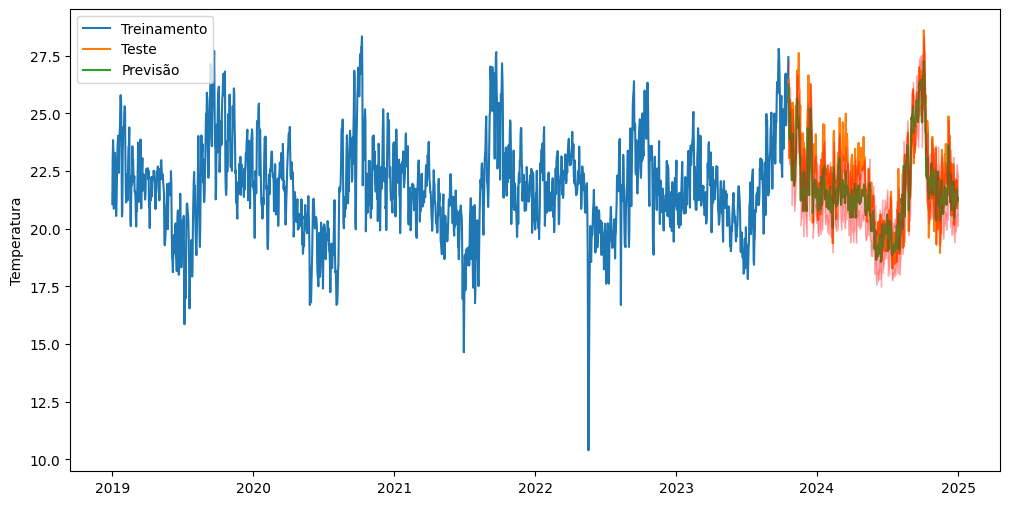

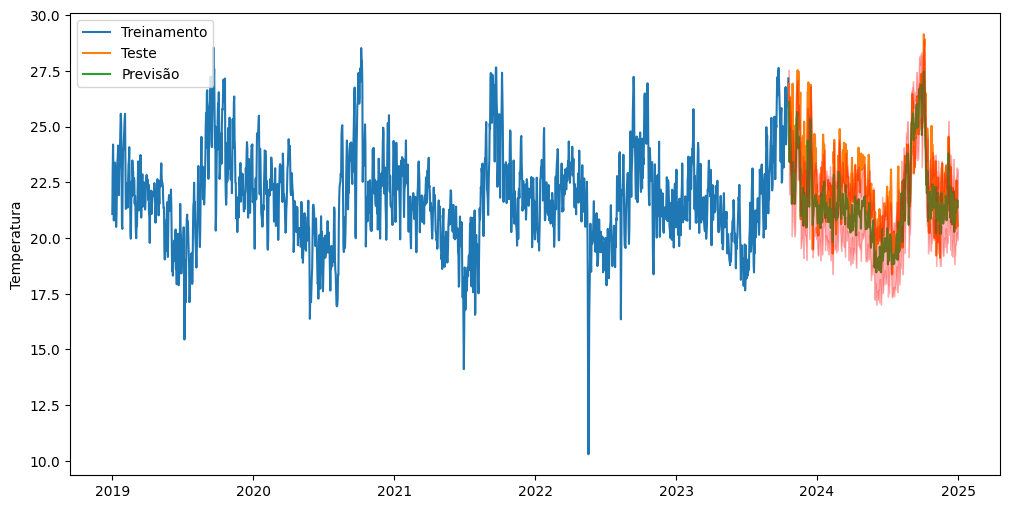

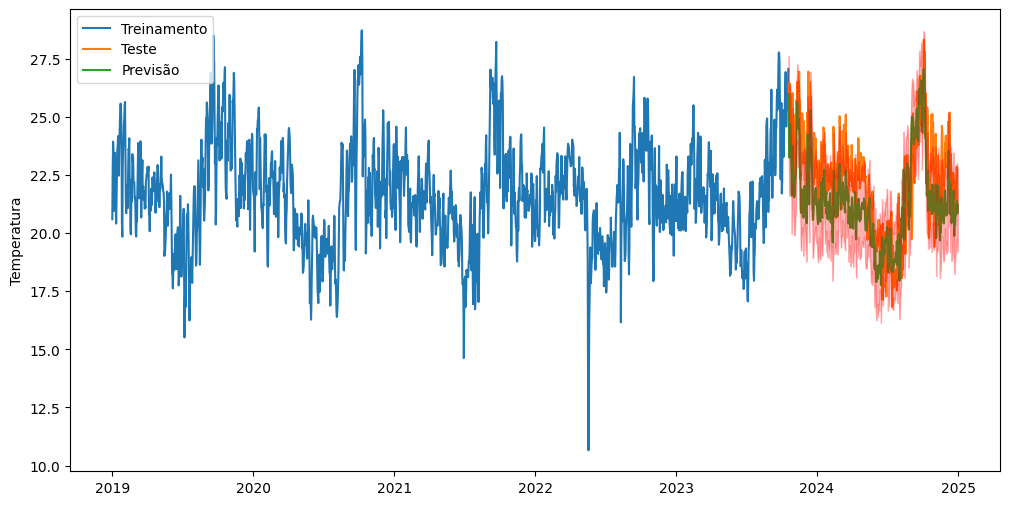

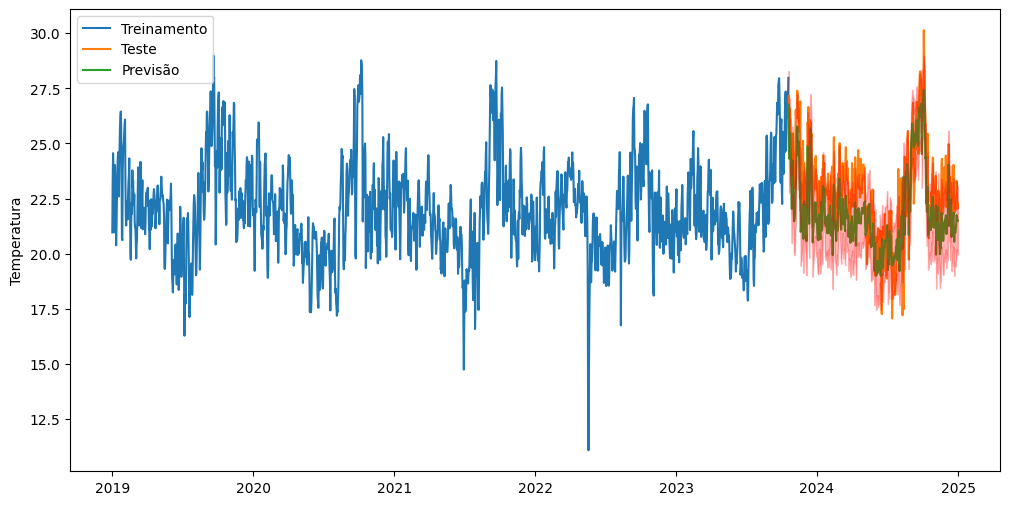

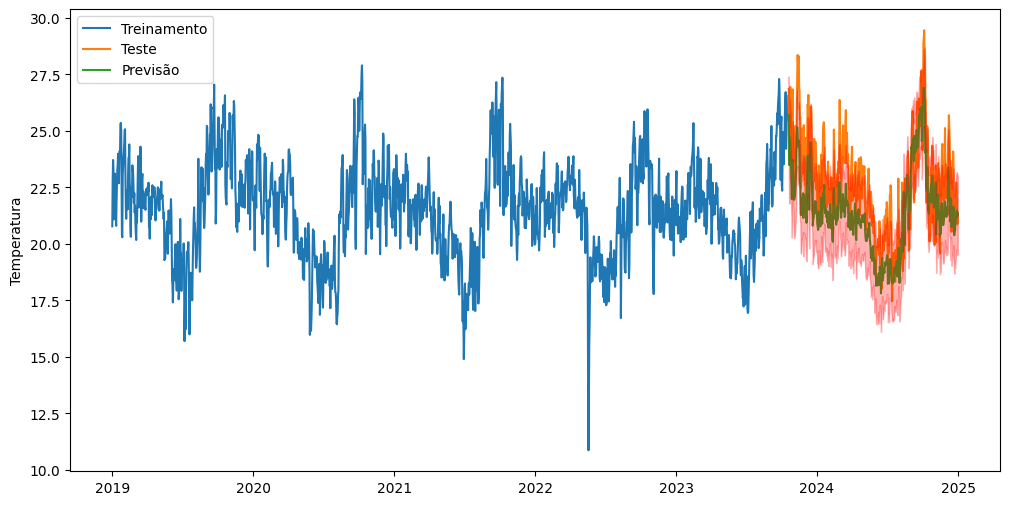

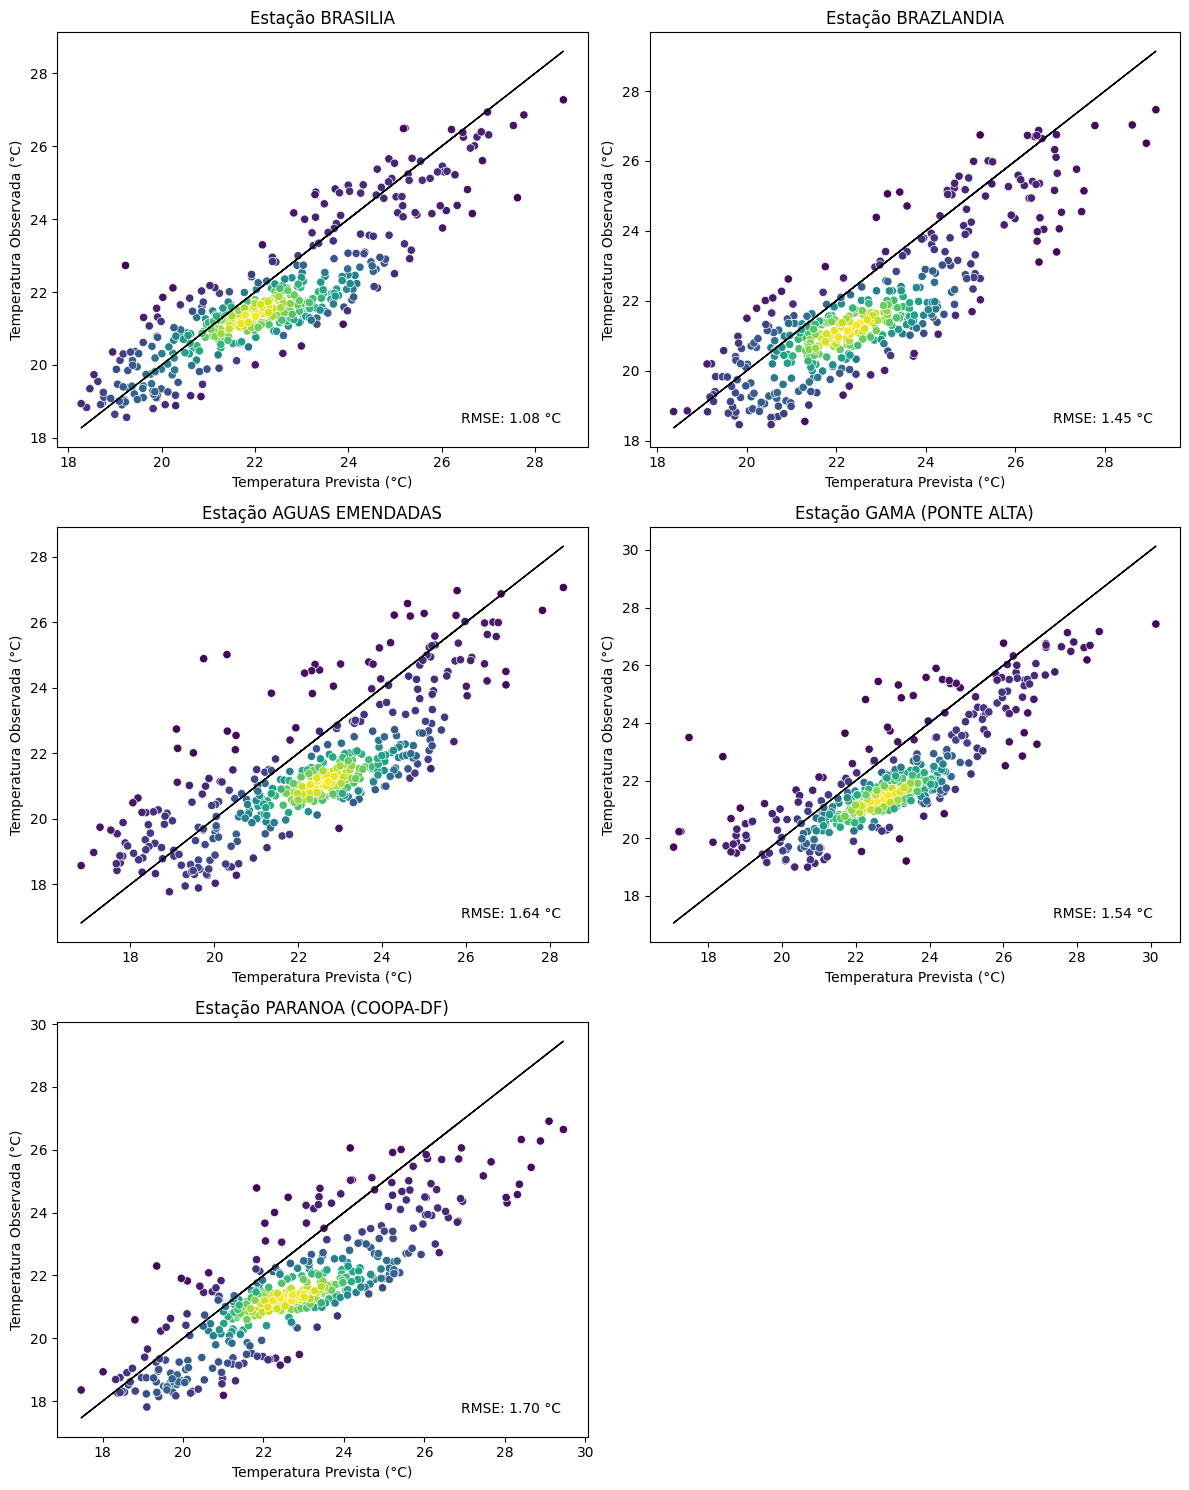

In [23]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import seaborn as sns

from pmdarima import auto_arima

# df_nearest_stations_weather_data = []

# for filename in df_nearest_stations['Arquivo']: 
#     df_weather_data = pd.read_csv(f'../data/cleaned_data/2023_cleaned/{filename}', decimal=".", sep=";")
#     df_nearest_stations_weather_data.append(df_weather_data)

# df_compilation_of_nearest_stations_weather_data = pd.concat(df_nearest_stations_weather_data, ignore_index= True)

def clean_data(dataframe):
    df_cleaned = dataframe.drop(columns=['Hora UTC'])
    df_cleaned['Data'] = pd.to_datetime(df_cleaned['Data'])

    df_sorted = df_cleaned.sort_values(by='Data', ascending=True)
    df_sorted.set_index('Data', inplace=True)
    df_avarage_temperature_by_day = df_sorted.resample("D").mean()
    df_not_null_values_day = df_avarage_temperature_by_day.ffill()

    return df_not_null_values_day

def create_fourier_terms(t, period, num_terms):
    terms = []
    for i in range(1, num_terms + 1):
        terms.append(np.sin(2 * np.pi * i * t / period))
        terms.append(np.cos(2 * np.pi * i * t / period))
    return np.column_stack(terms)

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


def get_forecast_test_graph(df_test, forecast, forecast_parameter, ax):
    import numpy as np
    from scipy import stats
    from sklearn.metrics import mean_squared_error
    import seaborn as sns

    values = np.vstack([df_test[forecast_parameter], forecast])
    kernel = stats.gaussian_kde(values)(values)

    # Scatterplot com seaborn no eixo fornecido
    sns.scatterplot(
        x=df_test[forecast_parameter],
        y=forecast,
        hue=kernel,
        palette="viridis",
        ax=ax,
        legend=False
    )

    mse = mean_squared_error(df_test[forecast_parameter], forecast)
    rmse = mse**0.5

    # Linha de referência x=y
    ax.plot(df_test[forecast_parameter], df_test[forecast_parameter], color='black', linewidth=1.0)

    # Texto RMSE
    ax.text(0.95, 0.05, f'RMSE: {rmse:.2f} °C', ha='right', va='bottom', transform=ax.transAxes, fontsize=10)

    ax.set_ylabel('Temperatura Observada (°C)')
    ax.set_xlabel('Temperatura Prevista (°C)')

def get_aggregated_graphs(df_tests, forecasts, forecast_parameter, stations_name):
    n_graphs = len(df_tests)
    n_cols = 2
    n_rows = (n_graphs + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
    axes = axes.flatten()

    for i in range(n_graphs):
        get_forecast_test_graph(df_tests[i], forecasts[i], forecast_parameter, ax=axes[i])
        axes[i].set_title(f'Estação {stations_name[i]}')

    # Remove os eixos extras se n_graphs for ímpar
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def arima_forecast_with_fourier_terms_exog(df_training, df_test, df_test_without_the_station, forecast_parameter, title):
    n = len(df_training[forecast_parameter])  # Number of data points
    t = np.arange(n)
    seasonality = 365

    num_fourier_terms = 4
    fourier_terms = create_fourier_terms(t, seasonality, num_fourier_terms)

    exog_vars = ["RADIACAO GLOBAL (KJ/m²)", "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)", "UMIDADE RELATIVA DO AR, HORARIA (%)"]

    X_train_extra = df_training[exog_vars].values
    X_test_extra = df_test_without_the_station[exog_vars].values

    X_train_final = np.hstack([X_train_extra, fourier_terms[:n]])

    # Fit the ARIMA model using arima with Fourier terms as exogenous variables
    model = ARIMA(df_training[forecast_parameter],exog=X_train_final, order=(1,0,0), trend='ct')
    model_fit = model.fit()

    # Forecast future values with the fitted model
    forecast_exog = create_fourier_terms(np.arange(n, n + len(df_test)), seasonality, num_fourier_terms)

    X_test_final = np.hstack([X_test_extra, forecast_exog])

    # Get the forecast for the future steps with exogenous variables
    # forecast_df = pd.DataFrame(forecast_exog, columns=[f'Fourier_{i+1}' for i in range(num_fourier_terms * 2)])

    # Fazer previsões
    forecast = model_fit.forecast(steps=len(df_test), exog=X_test_final)

    # Visualização das previsões
    plt.figure(figsize=(12,6))
    plt.plot(df_training.index, df_training[forecast_parameter], label='Treinamento')
    plt.plot(df_test.index, df_test[forecast_parameter], label='Teste')
    plt.plot(df_test.index, forecast, label='Previsão')
    plt.ylabel('Temperatura')
    plt.legend(loc='upper left')

    # Cálculo erro quadrático
    mse = mean_squared_error(df_test[forecast_parameter], forecast)
    rmse = mse**0.5
    smape_value = smape(df_test[forecast_parameter], forecast)
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'sMAPE: {smape_value}')
    plt.fill_between(df_test.index, (forecast-rmse), (forecast+rmse), alpha=.3, color='r', zorder=20)

    return forecast

forecasts = []
df_tests = []
stations_name = []
forecast_parameter = 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'
for station in stations_data:
    cleaned_station_data = clean_data(station["station_data"])
    cleaned_nearest_stations_data = clean_data(station["nearest_stations_data"])


    # Divisão dos dados em treinamento (80%) e teste (20%)- MONTHLY
    training_data_length = int(len(cleaned_nearest_stations_data) * 0.8)
    df_training = cleaned_nearest_stations_data[:training_data_length]
    df_test_without_the_station = cleaned_nearest_stations_data[training_data_length:]
    df_test = cleaned_station_data[training_data_length:]

    station_name = station["station_info"]["ESTAC?O:"].iloc[0]
    forecast = arima_forecast_with_fourier_terms_exog(df_training, df_test, df_test_without_the_station, forecast_parameter, f'Previsão da Temperatura na Estação - {station_name}')
    # df_training_month, df_test_month = df_not_null_values_month[:df_splited_data_month], df_not_null_values_month[df_splited_data_month:]  

    forecasts.append(forecast)
    df_tests.append(df_test)
    stations_name.append(station_name)


get_aggregated_graphs(df_tests, forecasts, forecast_parameter, stations_name)

 

In [24]:
# Encontre o índice da estação BRASILIA
idx_brasilia = None
for i, name in enumerate(stations_name):
    if "BRASILIA" in name.upper():
        idx_brasilia = i
        break

if idx_brasilia is not None:
    df_test = df_tests[idx_brasilia]
    forecast = forecasts[idx_brasilia]
    station_name = stations_name[idx_brasilia]
    df_forecast = pd.DataFrame({
        'data': df_test.index,
        'temperatura_observada': df_test[forecast_parameter].values,
        'temperatura_prevista': forecast,
        'estacao': station_name
    })
    # Salva em CSV
    df_forecast.to_csv("forecast_brasilia.csv", index=False, sep=";")
    print("Arquivo forecast_brasilia.csv criado com sucesso!")
else:
    print("Estação BRASILIA não encontrada em stations_name.")



Arquivo forecast_brasilia.csv criado com sucesso!


RMSE entre BAM e Observado: 1.66°C
RMSE entre temperatura observada e prevista: 1.08°C


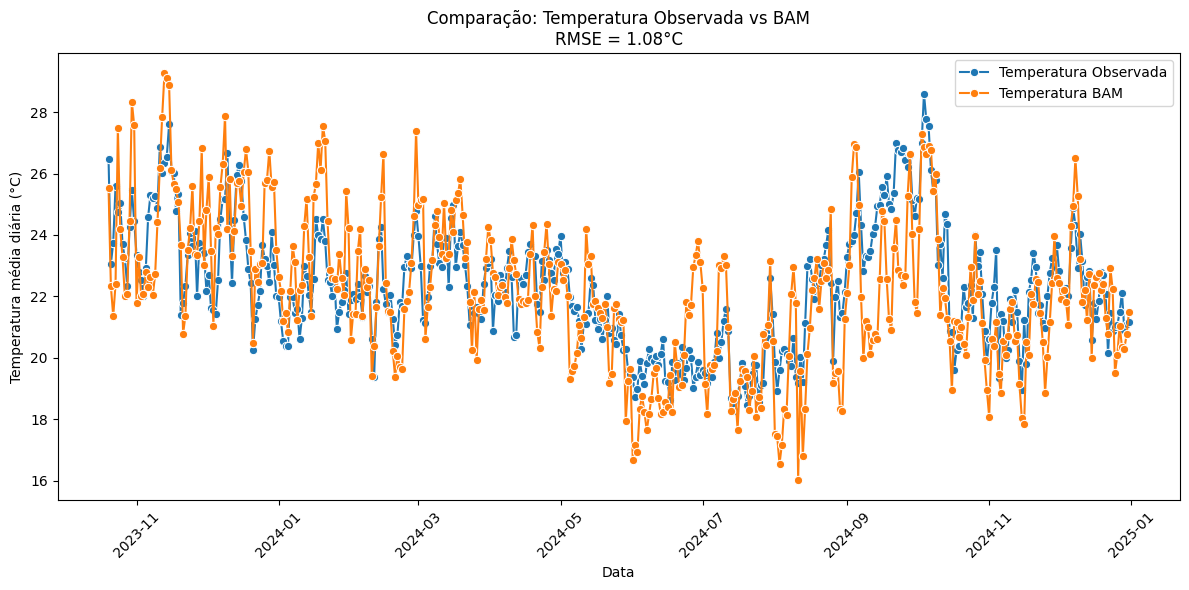

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Lê os arquivos
df_bam = pd.read_csv('bam_data.csv', sep=';')
df_obs = pd.read_csv('forecast_brasilia.csv', sep=';')

# Processa o arquivo BAM
df_bam['time'] = pd.to_datetime(df_bam['time'])
df_bam['date'] = df_bam['time'].dt.date
df_bam_daily = df_bam.groupby('date')['t2m'].mean().reset_index()
df_bam_daily.rename(columns={'t2m': 'temperatura_bam'}, inplace=True)

# Processa o arquivo Observado
df_obs['date'] = pd.to_datetime(df_obs['data']).dt.date

# Junta os dois dataframes pelas datas
df_merged = pd.merge(df_bam_daily, df_obs, on='date')

# Calcula RMSE entre BAM e Observado
rmse = np.sqrt(mean_squared_error(df_merged['temperatura_observada'], df_merged['temperatura_bam']))
print(f'RMSE entre BAM e Observado: {rmse:.2f}°C')

rmse = np.sqrt(mean_squared_error(df_obs['temperatura_observada'], df_obs['temperatura_prevista']))
print(f'RMSE entre temperatura observada e prevista: {rmse:.2f}°C')

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='temperatura_observada', data=df_merged, marker='o', label='Temperatura Observada')
sns.lineplot(x='date', y='temperatura_bam', data=df_merged, marker='o', label='Temperatura BAM')
plt.xlabel('Data')
plt.ylabel('Temperatura média diária (°C)')
plt.title('Comparação: Temperatura Observada vs BAM\nRMSE = {:.2f}°C'.format(rmse))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


RMSE entre temperatura observada e prevista: 1.08°C


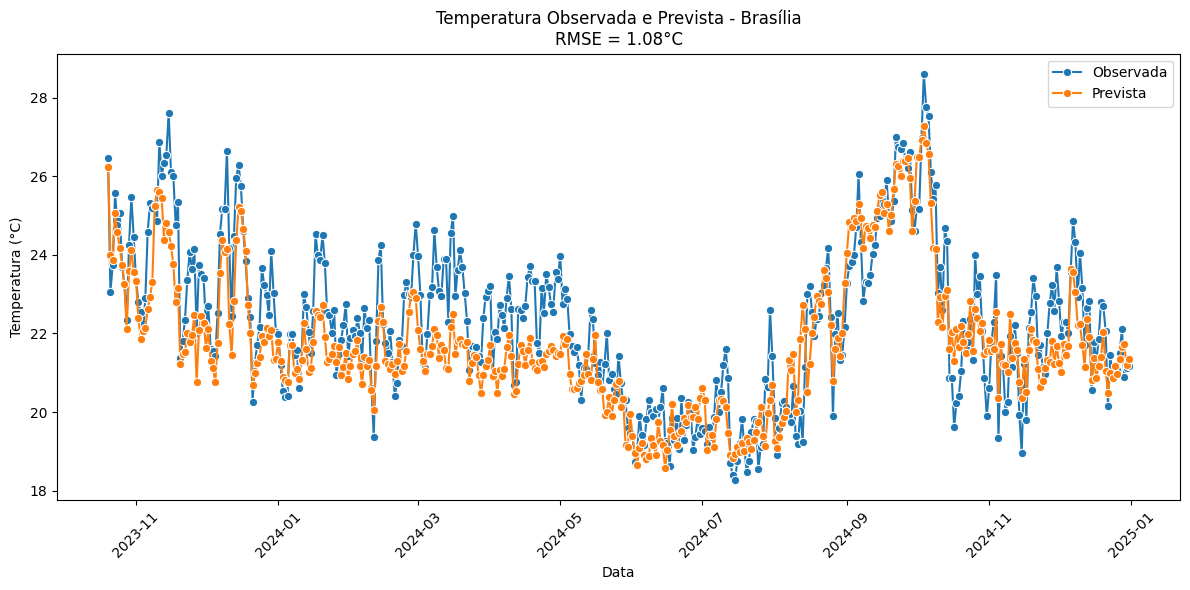

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Lê o CSV
df_obs = pd.read_csv('forecast_brasilia.csv', sep=';')

# Garante que 'data' está no formato datetime
df_obs['data'] = pd.to_datetime(df_obs['data'])

rmse = np.sqrt(mean_squared_error(df_obs['temperatura_observada'], df_obs['temperatura_prevista']))
print(f'RMSE entre temperatura observada e prevista: {rmse:.2f}°C')

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='data', y='temperatura_observada', data=df_obs, marker='o', label='Observada')
sns.lineplot(x='data', y='temperatura_prevista', data=df_obs, marker='o', label='Prevista')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.title(f'Temperatura Observada e Prevista - Brasília\nRMSE = {rmse:.2f}°C')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_3496/50289117.py:128: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_pred['temperatura_observada'] = df_pred['temperatura_observada'].combine_first(df_pred[col])


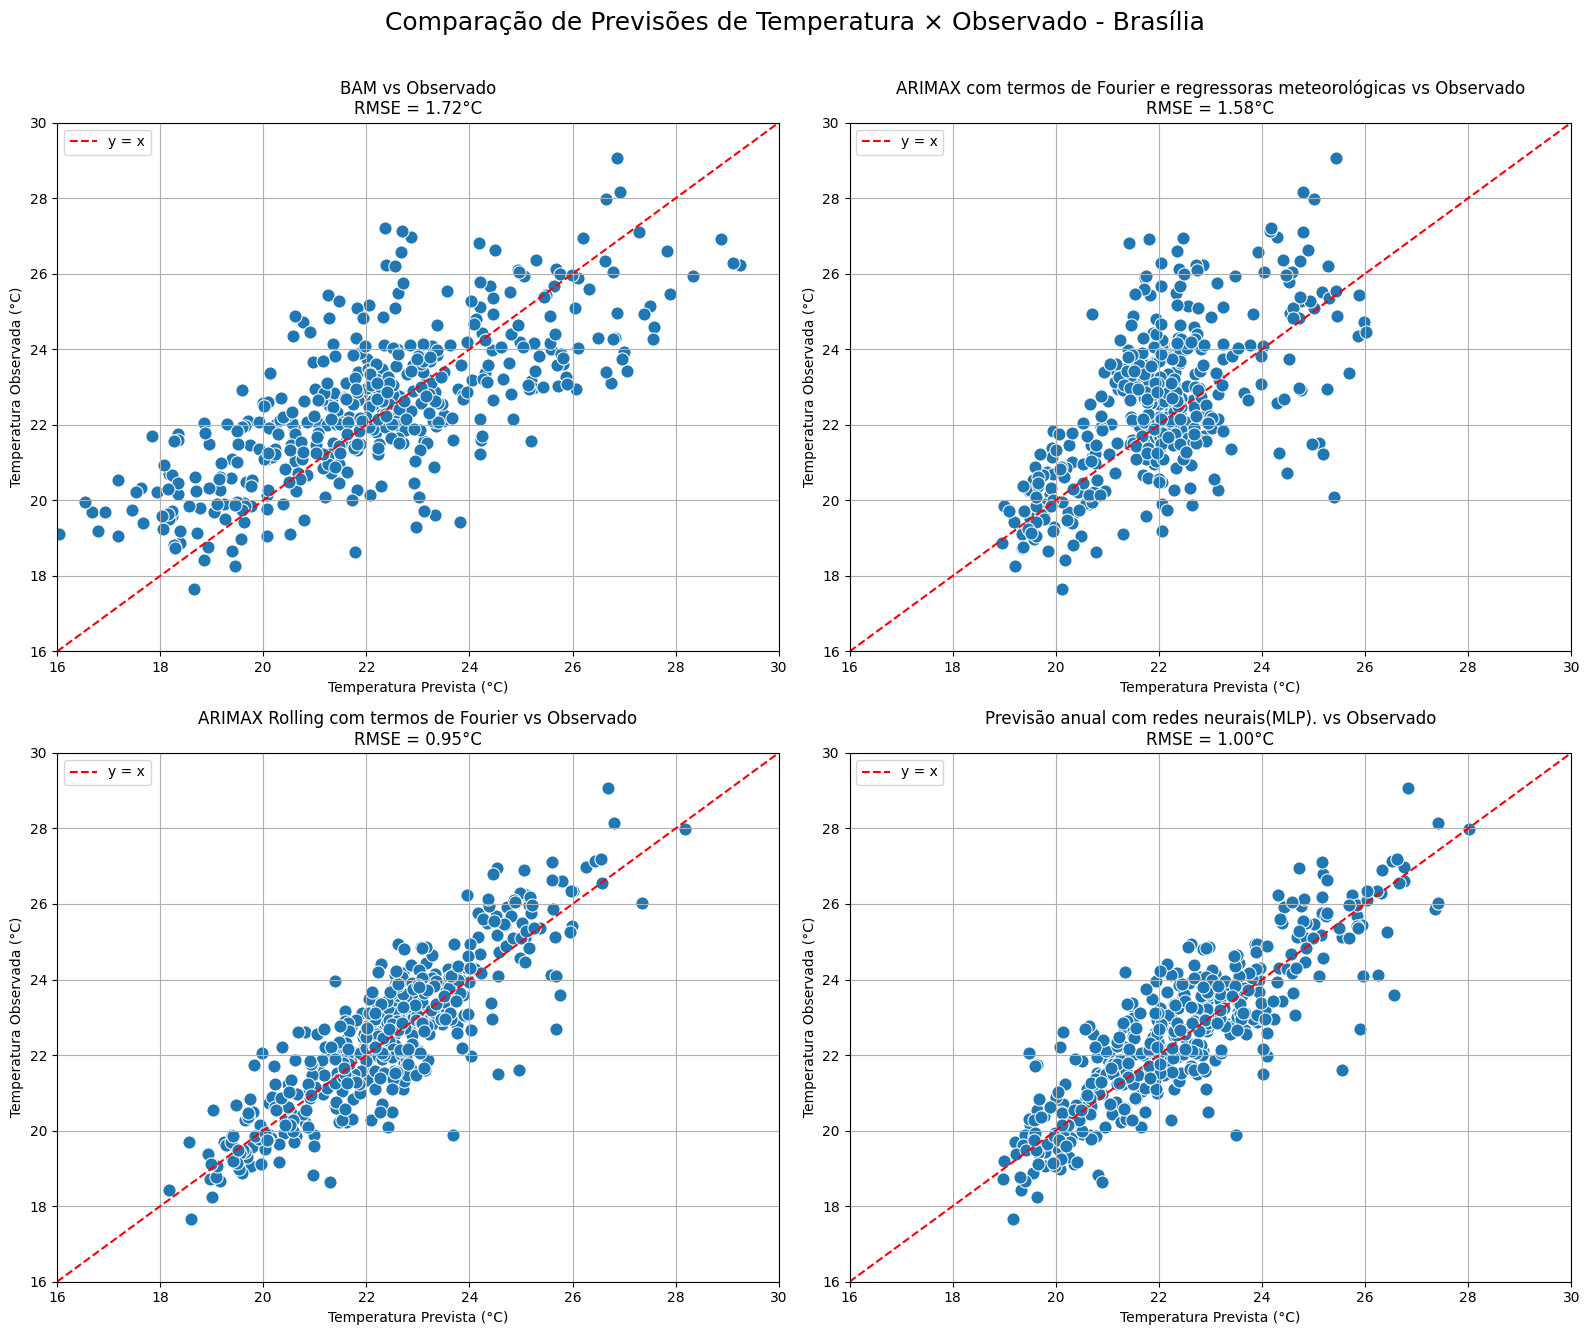

Registros pós-merge: 438 dias
RMSE (BAM vs Obs):     1.715 °C
RMSE (Fourier vs Obs): 1.585 °C
RMSE (Rolling vs Obs): 0.954 °C
RMSE (Neural Network vs Obs):     0.997 °C


In [30]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # Lê os arquivos
# df_bam = pd.read_csv('bam_data.csv', sep=';')
# df_obs = pd.read_csv('forecast_arima_fourier_exog.csv', sep=';')

# # Processa BAM
# df_bam['time'] = pd.to_datetime(df_bam['time'])
# df_bam['date'] = df_bam['time'].dt.date
# df_bam_daily = df_bam.groupby('date')['t2m'].mean().reset_index()
# df_bam_daily.rename(columns={'t2m': 'temperatura_bam'}, inplace=True)

# # Processa Observado
# df_obs['date'] = pd.to_datetime(df_obs['data']).dt.date
# # df_obs = df_obs[df_obs['estacao'] == 'BRASILIA']

# # Merge
# df_merged = pd.merge(df_bam_daily, df_obs, on='date')

# # Calcula RMSEs
# rmse_prevista = np.sqrt(mean_squared_error(df_merged['temperatura_observada'], df_merged['temperatura_prevista']))
# rmse_bam = np.sqrt(mean_squared_error(df_merged['temperatura_observada'], df_merged['temperatura_bam']))

# # Faixa de temperaturas para linha y=x
# min_temp = min(df_merged[['temperatura_bam', 'temperatura_prevista', 'temperatura_observada']].min())
# max_temp = max(df_merged[['temperatura_bam', 'temperatura_prevista', 'temperatura_observada']].max())

# # Cria painel
# fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# # Painel 1: Prevista x Observada
# sns.scatterplot(
#     x='temperatura_prevista',
#     y='temperatura_observada',
#     data=df_merged,
#     s=100,
#     ax=axs[0]
# )
# axs[0].plot([min_temp, max_temp], [min_temp, max_temp], 'r--', label='y = x')
# axs[0].set_xlabel('Temperatura Prevista (°C)')
# axs[0].set_ylabel('Temperatura Observada (°C)')
# axs[0].set_title(f'Prevista x Observada\nRMSE = {rmse_prevista:.2f}°C')
# axs[0].legend()
# axs[0].grid(True)

# # Painel 2: BAM x Observada
# sns.scatterplot(
#     x='temperatura_bam',
#     y='temperatura_observada',
#     data=df_merged,
#     s=100,
#     ax=axs[1]
# )
# axs[1].plot([min_temp, max_temp], [min_temp, max_temp], 'r--', label='y = x (Perfeita)')
# axs[1].set_xlabel('Temperatura BAM (°C)')
# axs[1].set_ylabel('Temperatura Observada (°C)')
# axs[1].set_title(f'BAM x Observada\nRMSE = {rmse_bam:.2f}°C')
# axs[1].legend()
# axs[1].grid(True)

# plt.suptitle('Comparação de Previsão de Temperatura x Observado - Brasília', fontsize=16)
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import numpy as np

# -----------------------------
# 1) Ler dados
# -----------------------------
df_bam      = pd.read_csv('bam_data.csv', sep=';')
df_fourier  = pd.read_csv('forecast_arima_fourier_exog.csv', sep=';')
df_rolling  = pd.read_csv('forecast_arima_rolling.csv', sep=';')
df_mlp      = pd.read_csv('forecast_mlp.csv', sep=';')

# -----------------------------
# 2) Processar BAM (média diária)
# -----------------------------
df_bam['time'] = pd.to_datetime(df_bam['time'])
df_bam['date'] = df_bam['time'].dt.date
df_bam_daily = (
    df_bam.groupby('date', as_index=False)['t2m']
    .mean()
    .rename(columns={'t2m': 'temperatura_bam'})
)

# -----------------------------
# 3) Função utilitária p/ processar previsões
# -----------------------------
def daily_from_forecast_csv(df, prefix):
    df = df.copy()
    df['date'] = pd.to_datetime(df['data']).dt.date
    return (
        df.groupby('date', as_index=False)[['temperatura_observada', 'temperatura_prevista']]
          .mean()
          .rename(columns={
              'temperatura_observada': f'temperatura_observada_{prefix}',
              'temperatura_prevista':  f'temperatura_prevista_{prefix}'
          })
    )

df_fourier_daily = daily_from_forecast_csv(df_fourier, 'fourier')
df_rolling_daily = daily_from_forecast_csv(df_rolling, 'rolling')
df_mlp_daily     = daily_from_forecast_csv(df_mlp,     'mlp')

# -----------------------------
# 4) Merge de previsões e definição do observado
# -----------------------------
from functools import reduce

dfs_pred = [df_fourier_daily, df_rolling_daily, df_mlp_daily]
df_pred = reduce(lambda l, r: pd.merge(l, r, on='date', how='outer'), dfs_pred)

df_pred['temperatura_observada'] = None
for col in [
    'temperatura_observada_fourier',
    'temperatura_observada_rolling',
    'temperatura_observada_mlp'
]:
    if col in df_pred:
        df_pred['temperatura_observada'] = df_pred['temperatura_observada'].combine_first(df_pred[col])

df_pred = df_pred[['date', 'temperatura_observada',
                   'temperatura_prevista_fourier',
                   'temperatura_prevista_rolling',
                   'temperatura_prevista_mlp']]

# -----------------------------
# 5) Merge com BAM
# -----------------------------
df_merged = pd.merge(df_bam_daily, df_pred, on='date', how='inner').dropna()

# -----------------------------
# 6) RMSEs
# -----------------------------
rmse_bam = np.sqrt(mean_squared_error(df_merged['temperatura_observada'], df_merged['temperatura_bam']))
rmse_fourier = np.sqrt(mean_squared_error(df_merged['temperatura_observada'], df_merged['temperatura_prevista_fourier']))
rmse_rolling = np.sqrt(mean_squared_error(df_merged['temperatura_observada'], df_merged['temperatura_prevista_rolling']))
rmse_mlp = np.sqrt(mean_squared_error(df_merged['temperatura_observada'], df_merged['temperatura_prevista_mlp']))

# -----------------------------
# 7) Faixa de temperaturas
# -----------------------------
cols_range = ['temperatura_bam', 'temperatura_prevista_fourier', 'temperatura_prevista_rolling', 'temperatura_prevista_mlp', 'temperatura_observada']
min_temp = float(np.floor(df_merged[cols_range].min().min()))
max_temp = float(np.ceil(df_merged[cols_range].max().max()))

# -----------------------------
# 8) Painel 2x2 na ordem pedida
# -----------------------------
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
ax = axs.ravel()

# (1) BAM vs Observado
sns.scatterplot(data=df_merged, x='temperatura_bam', y='temperatura_observada', s=90, ax=ax[0])
ax[0].plot([min_temp, max_temp], [min_temp, max_temp], 'r--', label='y = x')
ax[0].set(xlabel='Temperatura Prevista (°C)', ylabel='Temperatura Observada (°C)', title=f'BAM vs Observado\nRMSE = {rmse_bam:.2f}°C')
ax[0].legend(); ax[0].grid(True)
ax[0].set_xlim(min_temp, max_temp); ax[0].set_ylim(min_temp, max_temp)

# (2) ARIMAX Fourier vs Observado
sns.scatterplot(data=df_merged, x='temperatura_prevista_fourier', y='temperatura_observada', s=90, ax=ax[1])
ax[1].plot([min_temp, max_temp], [min_temp, max_temp], 'r--', label='y = x')
ax[1].set(xlabel='Temperatura Prevista (°C)', ylabel='Temperatura Observada (°C)', title=f'ARIMAX com termos de Fourier e regressoras meteorológicas vs Observado\nRMSE = {rmse_fourier:.2f}°C')
ax[1].legend(); ax[1].grid(True)
ax[1].set_xlim(min_temp, max_temp); ax[1].set_ylim(min_temp, max_temp)

# (3) ARIMAX Rolling vs Observado
sns.scatterplot(data=df_merged, x='temperatura_prevista_rolling', y='temperatura_observada', s=90, ax=ax[2])
ax[2].plot([min_temp, max_temp], [min_temp, max_temp], 'r--', label='y = x')
ax[2].set(xlabel='Temperatura Prevista (°C)', ylabel='Temperatura Observada (°C)', title=f'ARIMAX Rolling com termos de Fourier vs Observado\nRMSE = {rmse_rolling:.2f}°C')
ax[2].legend(); ax[2].grid(True)
ax[2].set_xlim(min_temp, max_temp); ax[2].set_ylim(min_temp, max_temp)

# (4) MLP vs Observado
sns.scatterplot(data=df_merged, x='temperatura_prevista_mlp', y='temperatura_observada', s=90, ax=ax[3])
ax[3].plot([min_temp, max_temp], [min_temp, max_temp], 'r--', label='y = x')
ax[3].set(xlabel='Temperatura Prevista (°C)', ylabel='Temperatura Observada (°C)', title=f'Previsão anual com redes neurais(MLP). vs Observado\nRMSE = {rmse_mlp:.2f}°C')
ax[3].legend(); ax[3].grid(True)
ax[3].set_xlim(min_temp, max_temp); ax[3].set_ylim(min_temp, max_temp)

plt.suptitle('Comparação de Previsões de Temperatura × Observado - Brasília', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# -----------------------------
# 9) (Opcional) Exportar consolidado
# -----------------------------
# df_merged.to_csv('comparacao_bam_fourier_rolling_mlp.csv', sep=';', index=False, encoding='utf-8-sig')

print(f"Registros pós-merge: {len(df_merged)} dias")
print(f"RMSE (BAM vs Obs):     {rmse_bam:.3f} °C")
print(f"RMSE (Fourier vs Obs): {rmse_fourier:.3f} °C")
print(f"RMSE (Rolling vs Obs): {rmse_rolling:.3f} °C")
print(f"RMSE (Neural Network vs Obs):     {rmse_mlp:.3f} °C")



